In [1]:
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import framework, models
from netam.common import pick_device, parameter_count_of_model

In [2]:
from netam.framework import load_shmoof_dataframes

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nicknames = ['59', '88', '97', 'small']

site_count=500
batch_size=1024
device = pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) # , sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)
    val_dataset.nickname = nickname
    return train_dataset, val_dataset

Using Metal Performance Shaders


In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 100

In [4]:
def train_and_evaluate(model_name, model_instance, train_dataset, val_dataset):
    print(f"\tTraining {model_name}...")
    if "cnn" in model_name:
        train_dataset.to(device)
        val_dataset.to(device)
        model_instance.to(device)
    burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
    
    train_history = burrito.multi_train(epochs=epochs, max_tries=3)
    best_val_loss = train_history['val_loss'].min()
    nickname = val_dataset.nickname
    Path(f"_ignore/model_comparison_pretrained/{nickname}").mkdir(parents=True, exist_ok=True)
    burrito.save_crepe(f"_ignore/{nickname}/{model_name}")

    # Record pre-training and post-training losses
    result = {'model_name': model_name, 'model': str(model_instance), 'parameter_count': parameter_count_of_model(model_instance), 'val_loss': best_val_loss, 'epochs_used': len(train_history)}
    return result

def comparison_of_data(model_instances, train_dataset, val_dataset):
    results_list = []

    for model_name, model_instance in model_instances.items():
        result = train_and_evaluate(model_name, model_instance, train_dataset, val_dataset)
        results_list.append(result)

    results_df = pd.DataFrame(results_list)
    return results_df

comparison_dfs = []
for nickname in val_nicknames:
    print(f"Val nickname is {nickname}")
    # train_dataset_1, val_dataset_1 = data_of_nickname(nickname, kmer_length=1)
    train_dataset_3, val_dataset_3 = data_of_nickname(nickname, kmer_length=3)
    train_dataset_5, val_dataset_5 = data_of_nickname(nickname, kmer_length=5)
    
    model_instances_1 = {
        # _ignore/optuna_CNN1merModel_20231125_071248.csv
        # Best Hyperparameters: {'kernel_size': 11, 'dropout': 0.2, 'num_filters': 17}
        # "cnn_1mer": models.CNN1merModel(train_dataset_1, num_filters=17, kernel_size=11, dropout_rate=0.2)
    }
    
    model_instances_3 = {
        "cnn_lrg_drp00": models.CNNModel(kmer_length=3, embedding_dim=8, filter_count=19, kernel_size=11, dropout_rate=0.0),
        "cnn_lrg_drp01": models.CNNModel(kmer_length=3, embedding_dim=8, filter_count=19, kernel_size=11, dropout_rate=0.1),
        "cnn_lrg_drp02": models.CNNModel(kmer_length=3, embedding_dim=8, filter_count=19, kernel_size=11, dropout_rate=0.2),
        "cnn_lrg_drp03": models.CNNModel(kmer_length=3, embedding_dim=8, filter_count=19, kernel_size=11, dropout_rate=0.3),
    }

    model_instances_5 = {
        "fivemer": models.FivemerModel(kmer_length=5),
        "shmoof": models.SHMoofModel(kmer_length=5, site_count=site_count),
    }
     
    comparison_df = \
        pd.concat([# comparison_of_data(model_instances_1, train_dataset_1, val_dataset_1),
                   comparison_of_data(model_instances_3, train_dataset_3, val_dataset_3),
                   comparison_of_data(model_instances_5, train_dataset_5, val_dataset_5)
                ])
    comparison_df["val_nickname"] = nickname

    # make val_nickname the first column
    cols = comparison_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    comparison_df = comparison_df[cols]

    comparison_dfs.append(comparison_df)

final_df = pd.concat(comparison_dfs)
final_df.to_csv(f"_ignore/model_comparison_{framework.timestamp_str()}.csv", index=False)
final_df
    

Val nickname is 59
	Training cnn_lrg_drp00...


Epoch:  27%|██▋       | 27/100 [00:03<00:09,  7.86it/s, loss_diff=-2.667e-06, lr=3.2e-5, val_loss=0.06362] 


	Training cnn_lrg_drp01...


Epoch:  31%|███       | 31/100 [00:03<00:08,  8.17it/s, loss_diff=-6.333e-08, lr=3.2e-5, val_loss=0.06138] 


	Training cnn_lrg_drp02...


Epoch:  46%|████▌     | 46/100 [00:05<00:06,  8.03it/s, loss_diff=-2.645e-07, lr=3.2e-5, val_loss=0.06063] 


	Training cnn_lrg_drp03...


Epoch:  28%|██▊       | 28/100 [00:03<00:08,  8.26it/s, loss_diff=-6.139e-06, lr=3.2e-5, val_loss=0.06911] 


	Training fivemer...


Epoch: 100%|██████████| 100/100 [00:02<00:00, 39.66it/s, loss_diff=-1.315e-06, lr=0.004, val_loss=0.05558]


Learning rate 0.004000000000000001 not below 0.0001. Resetting model and optimizer.


Epoch:  66%|██████▌   | 66/100 [00:01<00:00, 39.16it/s, loss_diff=-3.725e-09, lr=3.2e-5, val_loss=0.05551] 


	Training shmoof...


Epoch:  84%|████████▍ | 84/100 [00:02<00:00, 38.77it/s, loss_diff=7.451e-09, lr=3.2e-5, val_loss=0.05604] 


Val nickname is 88
	Training cnn_lrg_drp00...


Epoch:  39%|███▉      | 39/100 [00:04<00:07,  8.35it/s, loss_diff=-6.855e-07, lr=3.2e-5, val_loss=0.05744] 


	Training cnn_lrg_drp01...


Epoch:  35%|███▌      | 35/100 [00:04<00:07,  8.42it/s, loss_diff=9.537e-07, lr=3.2e-5, val_loss=0.05747] 


	Training cnn_lrg_drp02...


Epoch:  51%|█████     | 51/100 [00:06<00:06,  7.90it/s, loss_diff=2.049e-07, lr=3.2e-5, val_loss=0.05741] 


	Training cnn_lrg_drp03...


Epoch:  40%|████      | 40/100 [00:04<00:07,  8.38it/s, loss_diff=3.949e-07, lr=3.2e-5, val_loss=0.05787] 


	Training fivemer...


Epoch:  90%|█████████ | 90/100 [00:02<00:00, 38.35it/s, loss_diff=7.451e-09, lr=3.2e-5, val_loss=0.05365] 


	Training shmoof...


Epoch:  85%|████████▌ | 85/100 [00:02<00:00, 37.57it/s, loss_diff=1.863e-08, lr=3.2e-5, val_loss=0.05395] 


Val nickname is 97
	Training cnn_lrg_drp00...


Epoch:  61%|██████    | 61/100 [00:07<00:04,  7.99it/s, loss_diff=-6.855e-07, lr=3.2e-5, val_loss=0.06597] 


	Training cnn_lrg_drp01...


Epoch:  53%|█████▎    | 53/100 [00:06<00:05,  8.39it/s, loss_diff=1.341e-07, lr=3.2e-5, val_loss=0.06526] 


	Training cnn_lrg_drp02...


Epoch:  54%|█████▍    | 54/100 [00:07<00:05,  7.68it/s, loss_diff=1.192e-07, lr=3.2e-5, val_loss=0.06482] 


	Training cnn_lrg_drp03...


Epoch:  55%|█████▌    | 55/100 [00:06<00:05,  8.16it/s, loss_diff=2.831e-07, lr=3.2e-5, val_loss=0.06544] 


	Training fivemer...


Epoch:  43%|████▎     | 43/100 [00:01<00:01, 39.24it/s, loss_diff=-1.118e-07, lr=3.2e-5, val_loss=0.05702] 


	Training shmoof...


Epoch: 100%|██████████| 100/100 [00:02<00:00, 37.45it/s, loss_diff=-8.456e-07, lr=0.004, val_loss=0.05775]


Learning rate 0.004000000000000001 not below 0.0001. Resetting model and optimizer.


Epoch:  66%|██████▌   | 66/100 [00:01<00:00, 38.03it/s, loss_diff=7.451e-09, lr=3.2e-5, val_loss=0.05765] 


Val nickname is small
	Training cnn_lrg_drp00...


Epoch:  27%|██▋       | 27/100 [00:03<00:09,  7.82it/s, loss_diff=-4.809e-06, lr=3.2e-5, val_loss=0.05493] 


	Training cnn_lrg_drp01...


Epoch:  42%|████▏     | 42/100 [00:05<00:07,  8.05it/s, loss_diff=-1.863e-08, lr=3.2e-5, val_loss=0.04198]


	Training cnn_lrg_drp02...


Epoch:  47%|████▋     | 47/100 [00:06<00:06,  7.69it/s, loss_diff=1.341e-07, lr=3.2e-5, val_loss=0.04198] 


	Training cnn_lrg_drp03...


Epoch:  62%|██████▏   | 62/100 [00:07<00:04,  8.14it/s, loss_diff=5.215e-08, lr=3.2e-5, val_loss=0.04204] 


	Training fivemer...


Epoch:  56%|█████▌    | 56/100 [00:01<00:01, 37.99it/s, loss_diff=-6.333e-08, lr=3.2e-5, val_loss=0.05066] 


	Training shmoof...


Epoch:  78%|███████▊  | 78/100 [00:02<00:00, 37.49it/s, loss_diff=2.235e-08, lr=3.2e-5, val_loss=0.04963] 


,val_nickname,model_name,model,parameter_count,val_loss,epochs_used
0,59,cnn_lrg_drp00,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.062109,28
1,59,cnn_lrg_drp01,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.061335,32
2,59,cnn_lrg_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.060599,47
3,59,cnn_lrg_drp03,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.061900,29
0,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.055493,67
1,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.056032,85
0,88,cnn_lrg_drp00,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.057330,40
1,88,cnn_lrg_drp01,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.057295,36
2,88,cnn_lrg_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.057120,52
3,88,cnn_lrg_drp03,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.057705,41


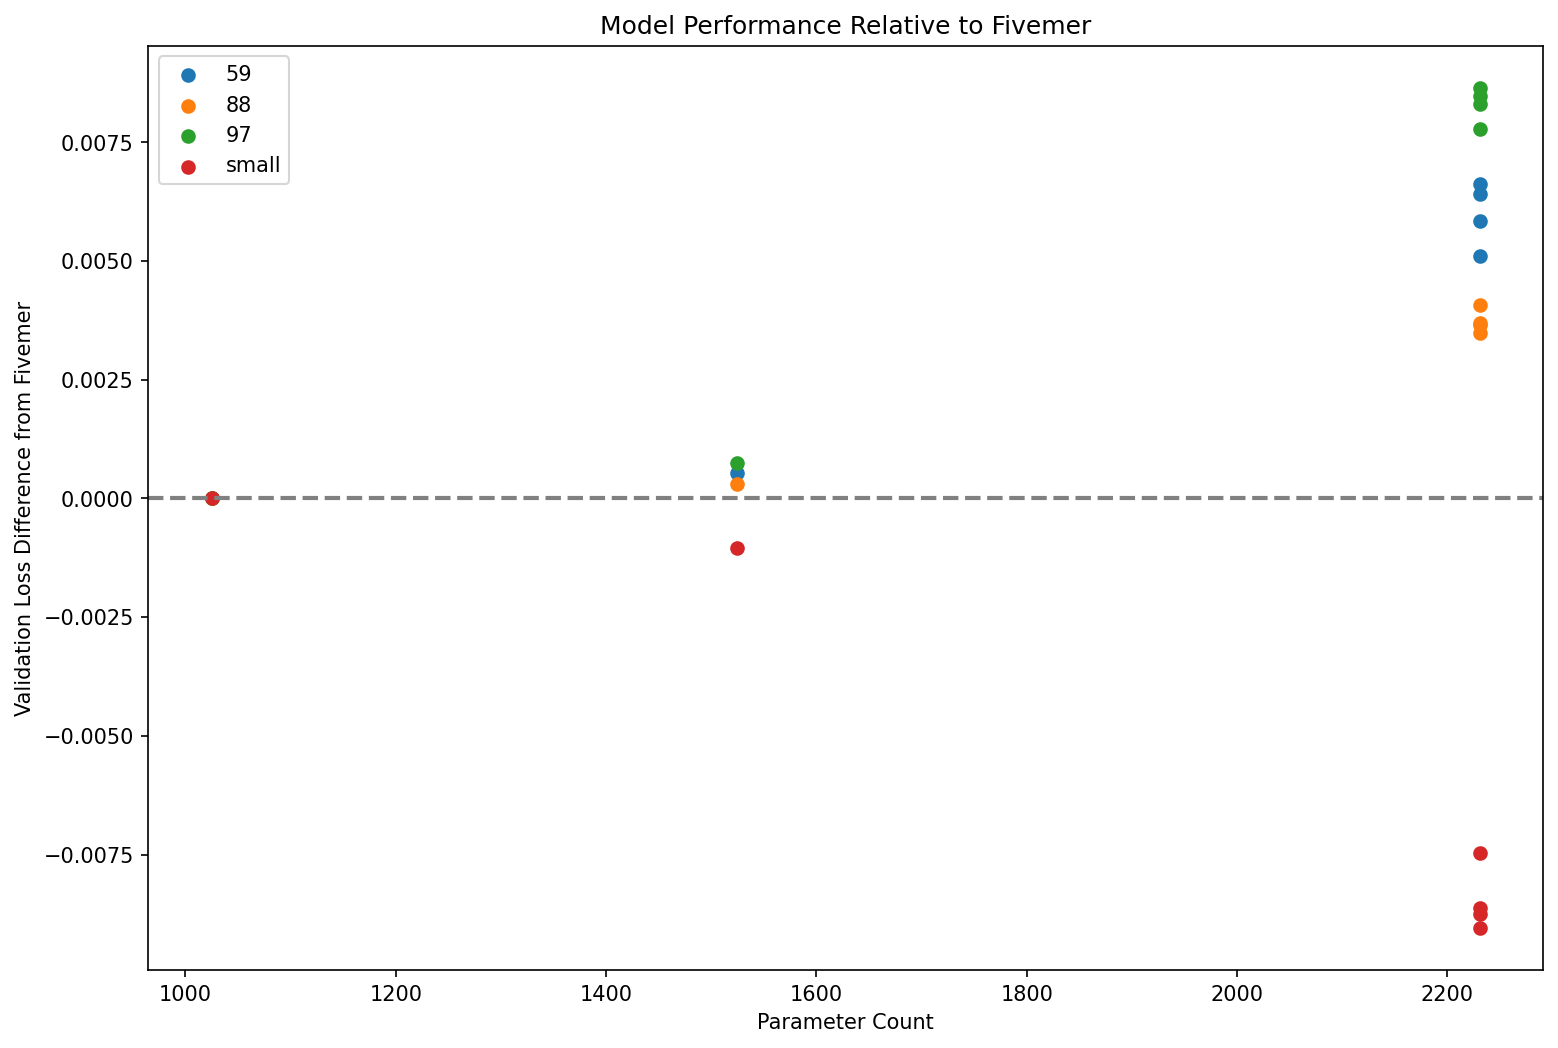

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            loss_diffs.append({'val_nickname': nickname, 'model': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame
loss_diff_df = pd.DataFrame(loss_diffs)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['parameter_count'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Parameter Count')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.legend()
plt.show()


/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_5984/2153285373.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")


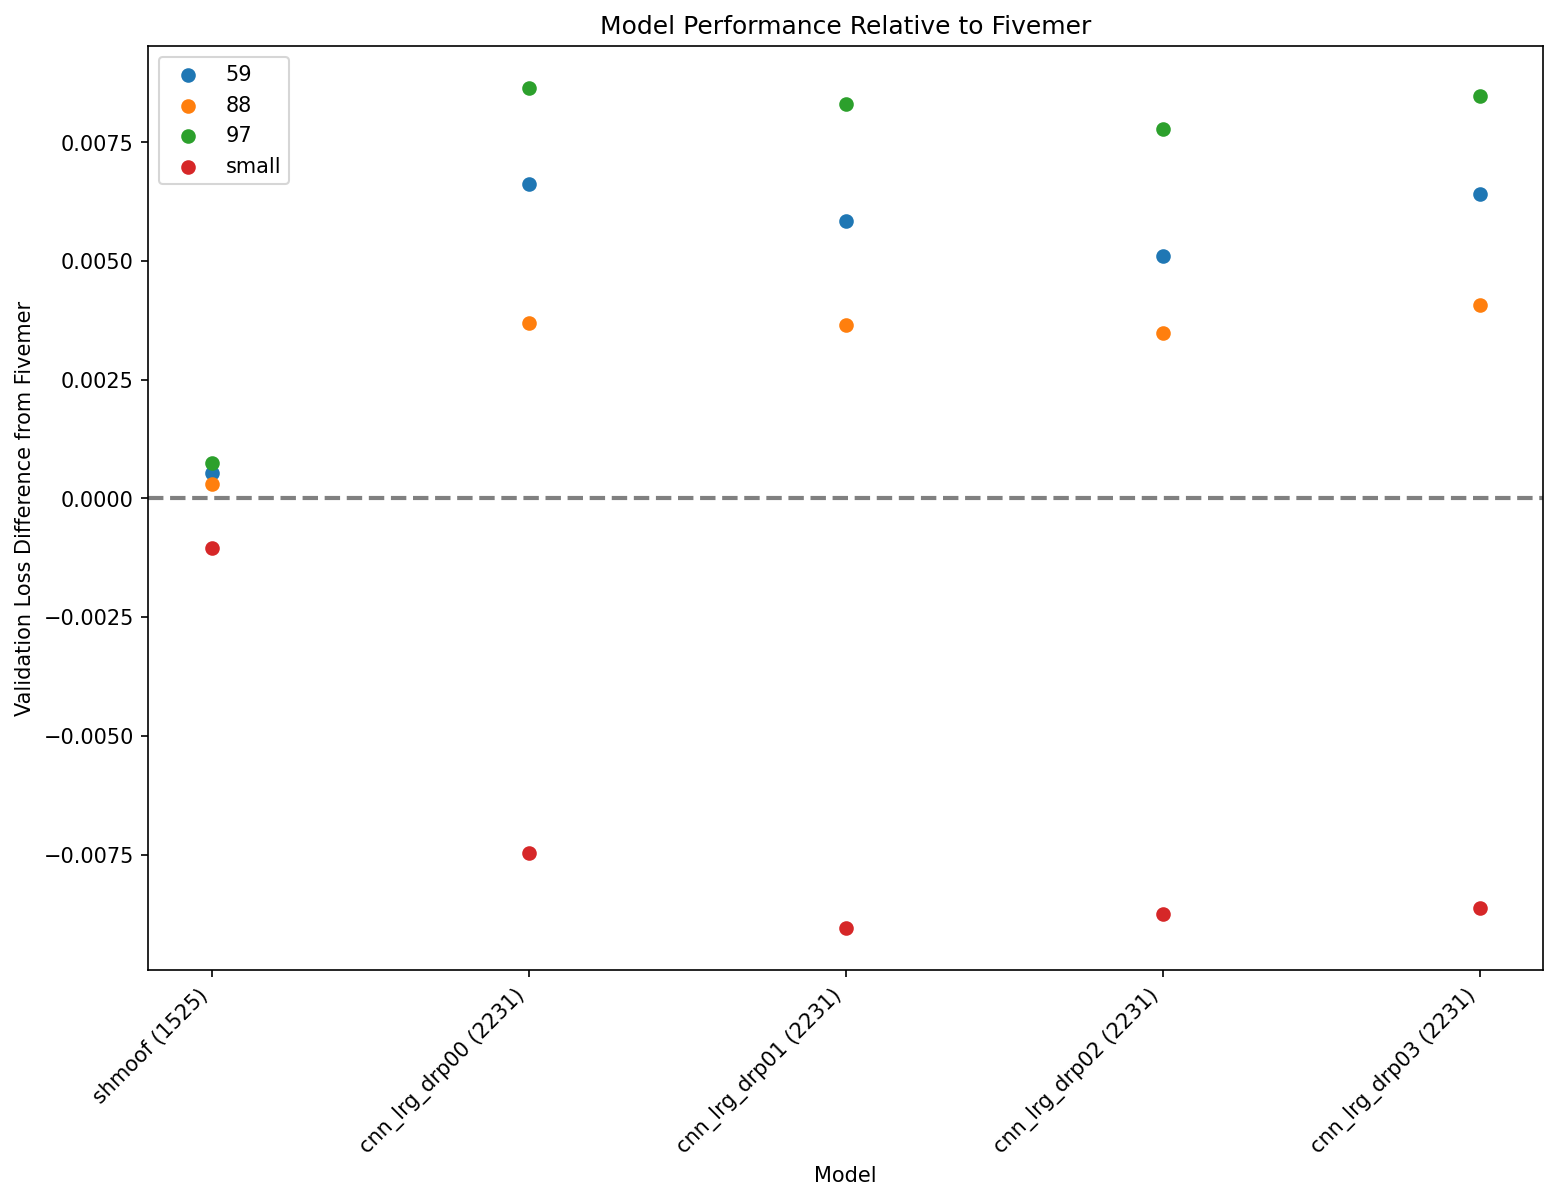

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df 

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
model_to_xlabel_str = {}
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model_name'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            model_label = f"{row['model_name']} ({row['parameter_count']})"
            model_to_xlabel_str[row['model_name']] = model_label
            loss_diffs.append({'val_nickname': nickname, 'model_name': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame and sort by parameter count
loss_diff_df = pd.DataFrame(loss_diffs)
# sort first by parameter count then by model name
loss_diff_df = loss_diff_df.sort_values(by=['parameter_count', 'model_name'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['model_name'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Model')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")
ax.legend()
plt.show()


In [7]:
final_df

,val_nickname,model_name,model,parameter_count,val_loss,epochs_used
0,59,cnn_lrg_drp00,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.062109,28
1,59,cnn_lrg_drp01,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.061335,32
2,59,cnn_lrg_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.060599,47
3,59,cnn_lrg_drp03,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.061900,29
0,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.055493,67
1,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.056032,85
0,88,cnn_lrg_drp00,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.057330,40
1,88,cnn_lrg_drp01,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.057295,36
2,88,cnn_lrg_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.057120,52
3,88,cnn_lrg_drp03,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",2231,0.057705,41
